<a href="https://colab.research.google.com/github/nayeem01/transaction-fraud-detection/blob/main/notebook/hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import datasets, pipeline
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

dataset reading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Mounted at /gdrive
/gdrive


In [ ]:
file = r'/gdrive/My Drive/Colab Notebooks/sorted_data10k.csv'
df = pd.read_csv(file)

X=df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest','newbalanceDest']]  
y=df['isFraud']  
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1,test_size=0.3)
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,58,TRANSFER,6501303.14,C2083819202,6501303.14,0.00,C1581398768,0.00,0.00,1,0
1,60,TRANSFER,45807.51,C958487787,45807.51,0.00,C218393296,0.00,0.00,1,0
2,60,TRANSFER,89014.32,C1517105060,89014.32,0.00,C621322132,0.00,0.00,1,0
3,60,CASH_OUT,40486.25,C1413149184,40486.25,0.00,C713338583,4716889.90,4757376.15,1,0
4,60,TRANSFER,40486.25,C46706219,40486.25,0.00,C1894539182,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,36,PAYMENT,12181.86,C1357754408,504485.30,492303.44,M1012233863,0.00,0.00,0,0
9996,36,CASH_IN,227951.15,C1257683794,59520.00,287471.15,C503650763,434866.17,206915.03,0,0
9997,36,PAYMENT,2373.64,C1374414349,187951.00,185577.36,M1815765224,0.00,0.00,0,0
9998,36,PAYMENT,6798.09,C2068628134,57108.00,50309.91,M69196470,0.00,0.00,0,0


In [ ]:
from imblearn.under_sampling import NearMiss

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify=y)

nr = NearMiss()
X_train, y_train = nr.fit_sample(X_train, y_train)
np.bincount(y_train)

array([856, 856])

In [ ]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify=y)
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)
np.bincount(y_train)

array([6644, 6644])

In [ ]:
pipe = pipeline.Pipeline([
    ('clf', lgb.LGBMClassifier())
    ])

param_gridsearch = {
    'clf__learning_rate' : [0.01, 0.1, 1],
    'clf__max_depth' : [5, 10, 15],
    'clf__n_estimators' : [5, 20, 35], 
    'clf__num_leaves' : [5, 25, 50],
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree' : [0.6, 0.75, 1],
    'clf__reg_lambda': [0.01, 0.1, 1],
}

param_random = {
    'clf__learning_rate': list(np.logspace(np.log(0.01), np.log(1), num = 500, base=3)),
    'clf__max_depth': list(range(5, 15)),
    'clf__n_estimators': list(range(5, 35)),
    'clf__num_leaves': list(range(5, 50)),
    'clf__boosting_type': ['gbdt', 'dart'],
    'clf__colsample_bytree': list(np.linspace(0.6, 1, 500)),
    'clf__reg_lambda': list(np.linspace(0, 1, 500)),
}

param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 35, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

In [ ]:
def search(pipeline, parameters, X_train, y_train, X_test, y_test, optimizer='grid_search', n_iter=None):
    
    start = time.time() 
    
    if optimizer == 'grid_search':
        grid_obj = GridSearchCV(estimator=pipeline,
                                param_grid=parameters,
                                cv=5,
                                refit=True,
                                return_train_score=False,
                                scoring = 'accuracy',
                               )
        grid_obj.fit(X_train, y_train,)
    
    elif optimizer == 'random_search':
        grid_obj = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=parameters,
                            cv=5,
                            n_iter=n_iter,
                            refit=True,
                            return_train_score=False,
                            scoring = 'accuracy',
                            random_state=1)
        grid_obj.fit(X_train, y_train,)
    
    else:
        print('enter search method')
        return

    estimator = grid_obj.best_estimator_
    cvs = cross_val_score(estimator, X_train, y_train, cv=5)
    results = pd.DataFrame(grid_obj.cv_results_)
    
    print("##### Results")
    print("Score best parameters: ", grid_obj.best_score_)
    print("Best parameters: ", grid_obj.best_params_)
    print("Cross-validation Score: ", cvs.mean())
    print("Test Score: ", estimator.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ",results.shape[0])
    
    return results, estimator

In [ ]:

num_eval =75
#results_grid, estimator_grid = search(pipe, param_gridsearch, X_train, y_train, X_test, y_test, 'grid_search')
results_random, estimator_random = search(pipe, param_random, X_train, y_train, X_test, y_test, 'random_search', num_eval)

##### Results
Score best parameters:  0.9976676384839649
Best parameters:  {'clf__reg_lambda': 0.024048096192384766, 'clf__num_leaves': 43, 'clf__n_estimators': 10, 'clf__max_depth': 14, 'clf__learning_rate': 0.7229292863898297, 'clf__colsample_bytree': 0.7226452905811623, 'clf__boosting_type': 'dart'}
Cross-validation Score:  0.9976676384839649
Test Score:  0.4216
Time elapsed:  3.7991268634796143
Parameter combinations evaluated:  75


In [ ]:

def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = lgb.LGBMClassifier(**params)
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
    else:
        boosting_type= 'dart'
    
    clf_best = lgb.LGBMClassifier(learning_rate=best_param_values[2],
                                  num_leaves=int(best_param_values[5]),
                                  max_depth=int(best_param_values[3]),
                                  n_estimators=int(best_param_values[4]),
                                  boosting_type=boosting_type,
                                  colsample_bytree=best_param_values[1],
                                  reg_lambda=best_param_values[6],
                                 )
                                  
    clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

In [ ]:
results_hyperopt = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval)


100%|██████████| 75/75 [00:05<00:00, 12.63it/s, best loss: -0.9976676384839649]

##### Results
Score best parameters:  0.9976676384839649
Best parameters:  {'boosting_type': 0, 'colsample_by_tree': 0.7109394344497755, 'learning_rate': 0.7554663099349869, 'max_depth': 14.0, 'n_estimators': 27.0, 'num_leaves': 32.0, 'reg_lambda': 0.060540396849595335}
Test Score:  0.5312
Time elapsed:  5.98123025894165
Parameter combinations evaluated:  75


In [ ]:
# Retrieve Hyperopt scores

hyperopt_scores = [trial['result']['loss']*-1 for trial in results_hyperopt.trials]
hyperopt_scores = np.maximum.accumulate(hyperopt_scores)

# Retrieve Random Search scores

random_scores = np.maximum.accumulate(results_random['mean_test_score'])

[None, None, None, None]

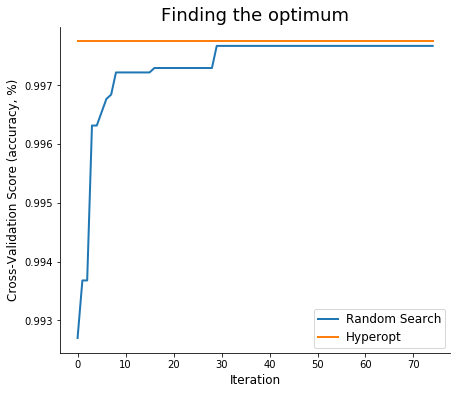

In [ ]:
# Plot evaluation scores of each method over time

f, ax = plt.subplots(figsize=(7,6))
sns.set_palette("husl")
sns.despine()
ax = sns.lineplot(x=[x for x in range(num_eval)], y=random_scores, linewidth = 2)
ax = sns.lineplot(x=[x for x in range(num_eval)], y=hyperopt_scores, linewidth = 2)
plt.title("Finding the optimum", fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cross-Validation Score (accuracy, %)', fontsize=12)
plt.legend(loc='lower right', labels=['Random Search', 'Hyperopt'])
plt.setp(ax.get_legend().get_texts(), fontsize='12')

In [ ]:

# Randomly sample from learning rate and num_leaves distribution

learning_rate_space = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1))}
num_leaves_space = {'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1))}

learning_rate_dist = [sample(learning_rate_space)['learning_rate'] for x in range(1000)]
num_leaves_dist = [sample(num_leaves_space)['num_leaves'] for x in range(1000)]

In [ ]:
num_eval =500
results_random, estimator_random = search(pipe, param_random, X_train, y_train, X_test, y_test, 'random_search', num_eval)
results_hyperopt = hyperopt(param_hyperopt, X_train, y_train, X_test, y_test, num_eval)

##### Results
Score best parameters:  0.9980434436004331
Best parameters:  {'clf__reg_lambda': 0.19639278557114226, 'clf__num_leaves': 16, 'clf__n_estimators': 33, 'clf__max_depth': 7, 'clf__learning_rate': 0.3778221856813538, 'clf__colsample_bytree': 0.632064128256513, 'clf__boosting_type': 'dart'}
Cross-validation Score:  0.9980434436004331
Test Score:  0.998
Time elapsed:  90.5651957988739
Parameter combinations evaluated:  500
100%|██████████| 500/500 [02:21<00:00,  2.61it/s, best loss: -0.9981940176480599]

##### Results
Score best parameters:  0.9981940176480599
Best parameters:  {'boosting_type': 0, 'colsample_by_tree': 0.660755781449866, 'learning_rate': 0.1639253772037669, 'max_depth': 9.0, 'n_estimators': 35.0, 'num_leaves': 26.0, 'reg_lambda': 0.02208950637190993}
Test Score:  0.9972
Time elapsed:  141.41037368774414
Parameter combinations evaluated:  500


In [ ]:
# Retrieve learning rates and num_leaves' used by Hyperopt

learning_rate_hp = [trial['misc']['vals']['learning_rate'][0] for trial in results_hyperopt.trials]
num_leaves_hp = [trial['misc']['vals']['num_leaves'][0] for trial in results_hyperopt.trials]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=35,max_depth=9,min_samples_leaf=26)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3668


[None, None, None, None]

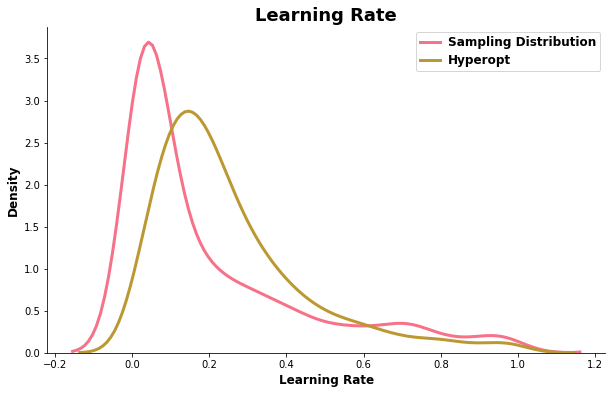

In [ ]:
# Plot learning rate sampling distribution vs. values used by Hyperopt

f, ax = plt.subplots(figsize=(10,6))
sns.set_palette("husl")
sns.despine()
ax = sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 3)
ax = sns.kdeplot(learning_rate_hp, label = 'Hyperopt', linewidth = 3)
plt.title("Learning Rate", fontsize=18, fontweight='bold')
plt.xlabel('Learning Rate', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold');
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12', fontweight='bold')


[None, None, None, None]

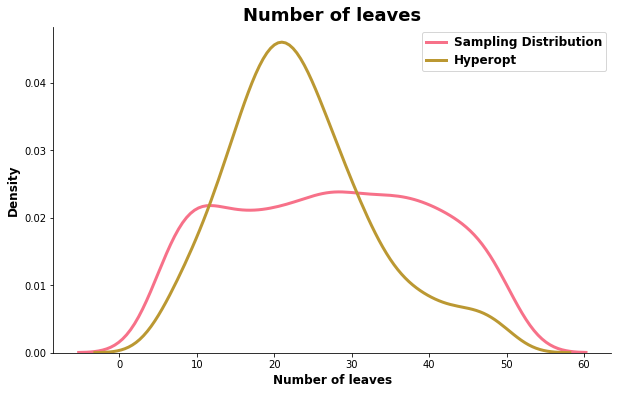

In [ ]:
# Plot num_leaves sampling distribution vs. values used by Hyperopt

f, ax = plt.subplots(figsize=(10,6))
sns.set_palette("husl")
sns.despine()
ax = sns.kdeplot(num_leaves_dist, label = 'Sampling Distribution', linewidth = 3)
ax = sns.kdeplot(num_leaves_hp, label = 'Hyperopt', linewidth = 3)
plt.title("Number of leaves", fontsize=18, fontweight='bold')
plt.xlabel('Number of leaves', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12', fontweight='bold')